# Рекурентные нейронки 

Посмотрим немного на рекурентные сетки. Будем смотреть на них на примере [потребления электроэнергии.](https://www.kaggle.com/uciml/electric-power-consumption-data-set)

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf 
tf.__version__

'2.0.0'

## 1. Какими бывают ячейки

Любая рекурентная ячейка может отдавать на выход либо полную последовательность либо только последний свой член. За это отвечает аргумент  `return_sequence`.

`SimpleRNN` - обычная RNN ячейка без изысков.
`LSTM` - LSTM ячейка
`GRU` - GRU ячейка

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Bidirectional

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


Рекурентные ячейки, как и обычные полносвязные, можно выстраивать в слои друг за другом. 

In [143]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # Последний выход должен выводить только последний результат
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Можно сделать модель двунаправленной.

In [5]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(5,10)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               24400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________


In [12]:
# model.variables[1] 

In [33]:
# LSTM()

tensorflow.python.keras.layers.recurrent_v2.LSTM

In [34]:
# GRU()

tensorflow.python.keras.layers.recurrent_v2.GRU

## 1. Данные

In [19]:
df = pd.read_csv('household_power_consumption.txt',
                  sep=';', na_values='?')
print(df.shape)
df.head()

(2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [20]:
df = df[:100000]

In [21]:
# удалили пропуски в целевой переменной 
df.dropna(subset = ['Global_active_power'], inplace=True)

# сделали дату датой
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['date_time'] = pd.to_datetime(df['date_time']) 

# распарсили дату на дни годы и тп 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)

# оставили только интересные колонки
df = df.loc[:,['date_time','Global_active_power', 
               'year','quarter','month','day']]

# отсортировали по дате 
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)

# дамми на выходные 
df["weekday"] = df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)

df.shape, df.date_time.min(), df.date_time.max()

((99992, 7),
 Timestamp('2006-12-16 17:24:00'),
 Timestamp('2007-12-02 23:59:00'))

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99992 entries, 0 to 99991
Data columns (total 7 columns):
date_time              99992 non-null datetime64[ns]
Global_active_power    99992 non-null float64
year                   99992 non-null int64
quarter                99992 non-null int64
month                  99992 non-null int64
day                    99992 non-null int64
weekday                99992 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 5.3 MB


Как AR, но лучше!

In [17]:
y = df.Global_active_power.values.astype('float32')
y

array([4.216, 5.36 , 5.374, ..., 0.332, 0.33 , 0.326], dtype=float32)

In [23]:
train_size = int(len(y) * 0.80)
test_size = len(y) - train_size

train, test = y[:train_size], y[train_size:]
train

array([4.216, 5.36 , 5.374, ..., 0.336, 0.34 , 0.424], dtype=float32)

In [24]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Как варим выборку: 

In [25]:
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# насколько сильно заглядывать в прошлое
n_steps = 5

# разбиение
X1, y1 = split_sequence(raw_seq, n_steps)
y1

array([60, 70, 80, 90])

In [26]:
X1

array([[10, 20, 30, 40, 50],
       [20, 30, 40, 50, 60],
       [30, 40, 50, 60, 70],
       [40, 50, 60, 70, 80]])

Проделаем это с нашей последовательностью.

In [27]:
n_steps  = 30
X_train, Y_train = split_sequence(train, n_steps)
X_test, Y_test = split_sequence(test, n_steps)

In [28]:
X_train

array([[4.216, 5.36 , 5.374, ..., 3.228, 3.258, 3.178],
       [5.36 , 5.374, 5.388, ..., 3.258, 3.178, 2.72 ],
       [5.374, 5.388, 3.666, ..., 3.178, 2.72 , 3.758],
       ...,
       [0.26 , 0.248, 0.25 , ..., 0.32 , 0.34 , 0.336],
       [0.248, 0.25 , 0.25 , ..., 0.34 , 0.336, 0.336],
       [0.25 , 0.25 , 0.25 , ..., 0.336, 0.336, 0.34 ]], dtype=float32)

In [30]:
# [samples, timesteps] => [samples, timesteps, features]

n_features = 1

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train.shape

(79963, 30, 1)

Можно учить модель!

In [32]:
model = Sequential()
model.add(LSTM(5, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [33]:
history = model.fit(X_train, Y_train, epochs=1, batch_size=70, 
                    validation_data=(X_test, Y_test), shuffle=False)

Train on 79963 samples, validate on 19969 samples
79963/79963 [==============================] - 20s 256us/sample - loss: 1.9858 - val_loss: 0.3399


In [34]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [35]:
from sklearn.metrics import mean_absolute_error as mae
mae(train[n_steps:], train_predict[:,0])

0.36613616

In [36]:
mae(test[n_steps:], test_predict[:,0])

0.2915765

W1121 17:41:23.455175 140735873860544 legend.py:1289] No handles with labels found to put in legend.


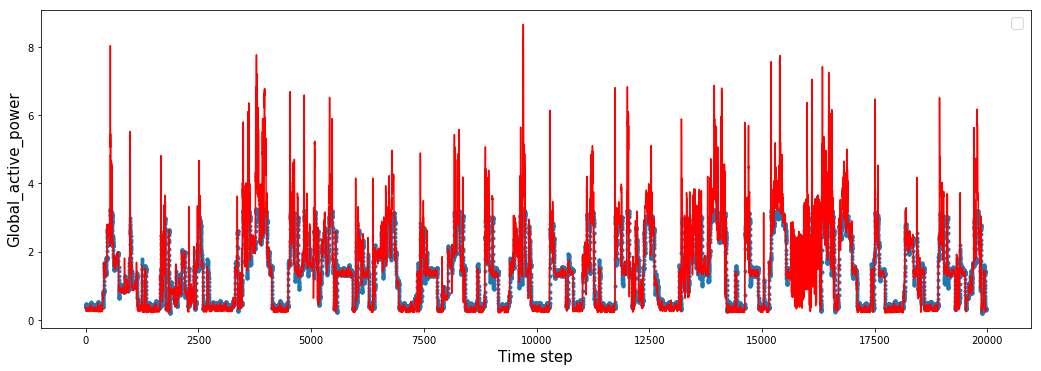

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(test_predict[:,0], marker='.')
plt.plot(test[n_steps:], 'r')
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

Что можно попробовать? 

* Стекнуть два слоя из LSTM
* Добавить в X больше фичей!

* __НЕЛЬЗЯ__ делать модель двунаправленной!

## Почиташки: 

* [Большой гайд с разными рекурентными сетками](https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/)
* [Его продолжение на данных про авиаперевозки](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) 
* [Код с потреблением электроенергии](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)